# Import Libraries

In [3]:
#LSTM for regression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
import sklearn
import seaborn as sns
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy import asarray
from sklearn.ensemble import RandomForestRegressor
from pandas import concat
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
from tensorflow import keras

# Data Pre-Processing

In [4]:
coffee_data = pd.read_excel('coffee_data.xlsx')

In [5]:
coffee_data

,Tên_mặt_hàng,Đơn_vị_tính,Loại_giá,Loại_tiền,Ngày,Giá
0,Cà phê Robusta nhân xô,VNĐ/kg,Thu mua,VNĐ,2021-01-01,31667.5
1,Cà phê Robusta nhân xô,Vnđ/kg,Thu mua,VNĐ,2021-01-04,32717.0
2,Cà phê Robusta nhân xô,Vnđ/kg,Thu mua,VNĐ,2021-01-05,32417.0
3,Cà phê Robusta nhân xô,Vnđ/kg,Thu mua,VNĐ,2021-01-06,32317.0
4,Cà phê Robusta nhân xô,Vnđ/kg,Thu mua,VNĐ,2021-01-07,32117.0
...,...,...,...,...,...,...
619,Cà phê Robusta nhân xô,Vnđ/kg,Thu mua,VNĐ,2023-05-15,55566.5
620,Cà phê Robusta nhân xô,Vnđ/kg,Thu mua,VNĐ,2023-05-16,56066.5
621,Cà phê Robusta nhân xô,Vnđ/kg,Thu mua,VNĐ,2023-05-17,56666.5
622,Cà phê Robusta nhân xô,Vnđ/kg,Thu mua,VNĐ,2023-05-18,57000.0


In [6]:
coffee_data['Ngày'] = pd.to_datetime(coffee_data['Ngày'])
coffee_data.drop(coffee_data.columns[[0, 1, 2, 3]], axis=1, inplace=True)
coffee_data

,Ngày,Giá
0,2021-01-01,31667.5
1,2021-01-04,32717.0
2,2021-01-05,32417.0
3,2021-01-06,32317.0
4,2021-01-07,32117.0
...,...,...
619,2023-05-15,55566.5
620,2023-05-16,56066.5
621,2023-05-17,56666.5
622,2023-05-18,57000.0


In [7]:
coffee_data['Giá'].astype(float)

0      31667.5
1      32717.0
2      32417.0
3      32317.0
4      32117.0
        ...   
619    55566.5
620    56066.5
621    56666.5
622    57000.0
623    57500.0
Name: Giá, Length: 624, dtype: float64

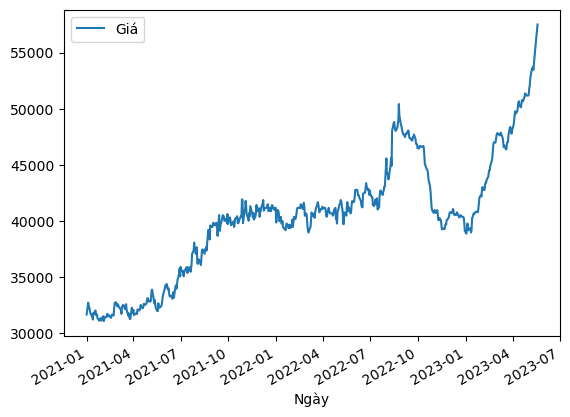

In [8]:
coffee_data.plot(x = 'Ngày', y = 'Giá')
plt.show()

In [9]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [10]:
coffee_data.drop(coffee_data.columns[[0]], axis = 1, inplace=True)

In [11]:
coffee_data.dropna()

,Giá
0,31667.5
1,32717.0
2,32417.0
3,32317.0
4,32117.0
...,...
619,55566.5
620,56066.5
621,56666.5
622,57000.0


In [32]:
coffee_data[-10:]

,Giá
614,53516.5
615,53466.5
616,53716.5
617,53466.5
618,54016.5
619,55566.5
620,56066.5
621,56666.5
622,57000.0
623,57500.0


In [12]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(coffee_data.values)

In [13]:
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = sklearn.metrics.mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

In [14]:
# calculate metrics
def print_metrics(test, pre_test):
    
    print('\nRMSE')
    testScore = np.sqrt(mean_squared_error(test,pre_test))
    print('Test Score: %.2f RMSE' % (testScore))
    
    print('\nMAE')
    testScore = sklearn.metrics.mean_absolute_error(test, pre_test)
    print('Test Score: %.2f MAE' % (testScore))
    
    print('\nMAPE')                          
    testScore = sklearn.metrics.mean_absolute_percentage_error(test, pre_test)
    print('Test Score: %.2f MAPE' % (testScore))
    
    print('\nMASE')
    testScore = mean_absolute_scaled_error(test, pre_test, test)
    print('Test Score: %.2f MASE' % (testScore))

# LSTM

In [15]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

436 188


In [16]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [17]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [18]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [19]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(434, 1, 1)
(434,)
(186, 1, 1)
(186,)


In [20]:
checkpoint_path = "models/LSTM.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, callbacks=[cp_callback])

Epoch 1/100

Epoch 1: saving model to models\LSTM.ckpt
434/434 - 2s - loss: 0.0306 - 2s/epoch - 4ms/step
Epoch 2/100

Epoch 2: saving model to models\LSTM.ckpt
434/434 - 0s - loss: 0.0106 - 381ms/epoch - 878us/step
Epoch 3/100

Epoch 3: saving model to models\LSTM.ckpt
434/434 - 0s - loss: 0.0040 - 374ms/epoch - 862us/step
Epoch 4/100

Epoch 4: saving model to models\LSTM.ckpt
434/434 - 0s - loss: 9.2035e-04 - 376ms/epoch - 865us/step
Epoch 5/100

Epoch 5: saving model to models\LSTM.ckpt
434/434 - 0s - loss: 4.1415e-04 - 384ms/epoch - 885us/step
Epoch 6/100

Epoch 6: saving model to models\LSTM.ckpt
434/434 - 0s - loss: 3.9720e-04 - 401ms/epoch - 925us/step
Epoch 7/100

Epoch 7: saving model to models\LSTM.ckpt
434/434 - 0s - loss: 3.8848e-04 - 495ms/epoch - 1ms/step
Epoch 8/100

Epoch 8: saving model to models\LSTM.ckpt
434/434 - 0s - loss: 3.8398e-04 - 389ms/epoch - 895us/step
Epoch 9/100

Epoch 9: saving model to models\LSTM.ckpt
434/434 - 0s - loss: 4.0062e-04 - 371ms/epoch - 856u

Epoch 72/100

Epoch 72: saving model to models\LSTM.ckpt
434/434 - 0s - loss: 3.8706e-04 - 362ms/epoch - 835us/step
Epoch 73/100

Epoch 73: saving model to models\LSTM.ckpt
434/434 - 0s - loss: 3.7760e-04 - 383ms/epoch - 883us/step
Epoch 74/100

Epoch 74: saving model to models\LSTM.ckpt
434/434 - 0s - loss: 3.8750e-04 - 372ms/epoch - 857us/step
Epoch 75/100

Epoch 75: saving model to models\LSTM.ckpt
434/434 - 0s - loss: 3.8464e-04 - 366ms/epoch - 844us/step
Epoch 76/100

Epoch 76: saving model to models\LSTM.ckpt
434/434 - 0s - loss: 3.8464e-04 - 370ms/epoch - 853us/step
Epoch 77/100

Epoch 77: saving model to models\LSTM.ckpt
434/434 - 0s - loss: 3.8610e-04 - 367ms/epoch - 845us/step
Epoch 78/100

Epoch 78: saving model to models\LSTM.ckpt
434/434 - 0s - loss: 3.8853e-04 - 371ms/epoch - 856us/step
Epoch 79/100

Epoch 79: saving model to models\LSTM.ckpt
434/434 - 0s - loss: 4.0682e-04 - 369ms/epoch - 851us/step
Epoch 80/100

Epoch 80: saving model to models\LSTM.ckpt
434/434 - 0s - 

In [21]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

6/6 [==============================] - 0s 1ms/step


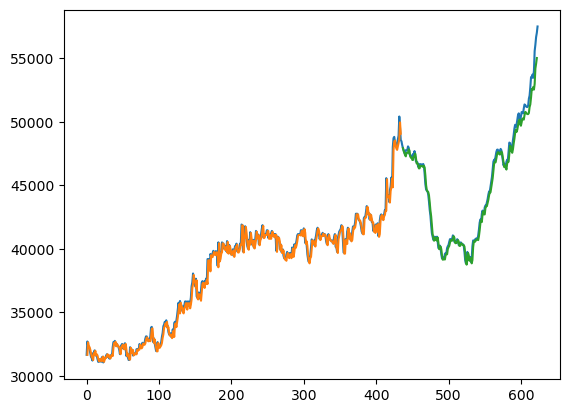

In [22]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [38]:
len(dataset)

624

In [30]:
# Create a DataFrame with the 'predicted coffee price' column
df_predict = pd.DataFrame(testPredict[-10:], columns=['predicted coffee price'])

In [31]:
df_predict

,predicted coffee price
0,51374.324219
1,51917.132812
2,52572.644531
3,52532.078125
4,52734.343750
5,52532.078125
6,52975.253906
7,54188.605469
8,54568.800781
9,55017.832031


# Random Forest

In [21]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [22]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

In [23]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, test_size = n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    return test[:, 1], predictions

In [24]:
data = series_to_supervised(dataframe, n_in=1)

In [25]:
y, predict = walk_forward_validation(data, 0.3)

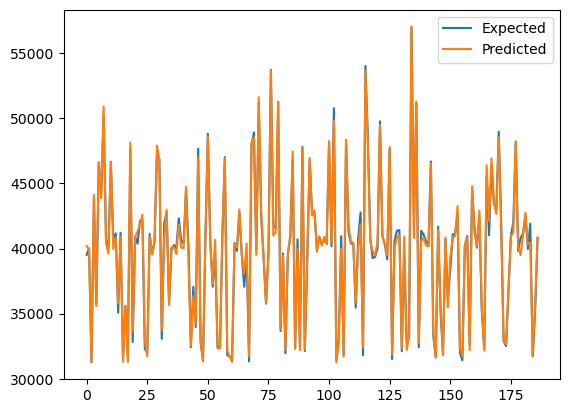

In [28]:
# plot expected vs predicted
plt.plot(y, label='Expected')
plt.plot(predict, label='Predicted')
plt.legend()
plt.show()

In [26]:
print_metrics(y, predict)


RMSE
Test Score: 455.71 RMSE

MAE
Test Score: 341.28 MAE

MAPE
Test Score: 0.01 MAPE

MASE
Test Score: 0.06 MASE


In [29]:
print_metrics(testY[0], testPredict[:,0])


RMSE
Test Score: 478.54 RMSE

MAE
Test Score: 342.12 MAE

MAPE
Test Score: 0.01 MAPE

MASE
Test Score: 1.35 MASE
